In [22]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
import nltk
import joblib
# Download the WordNet resource
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df_train = pd.read_csv('/content/twitter_training.csv')
df_val = pd.read_csv('/content/twitter_validation.csv')
df = pd.concat([df_train, df_val], ignore_index=False)
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,2401.0,Borderlands,Positive,I am coming to the borders and I will kill you...,NaN,NaN,NaN,NaN
1,2401.0,Borderlands,Positive,im getting on borderlands and i will kill you ...,NaN,NaN,NaN,NaN
2,2401.0,Borderlands,Positive,im coming on borderlands and i will murder you...,NaN,NaN,NaN,NaN
3,2401.0,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,NaN,NaN,NaN,NaN
4,2401.0,Borderlands,Positive,im getting into borderlands and i can murder y...,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75680 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                              --------------  -----  
 0   2401                                                                                                                                                                                                                                                74681 non-null  float64
 1   Borderlands                                                                

In [7]:
print(df.columns)

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,', '3364',
       'Facebook', 'Irrelevant',
       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'],
      dtype='object')


In [8]:
# prompt:  drop all columns except these columns (Borderlands, Positive, im getting on borderlands and i will murder you all ,) and rename to (Branch, Sentiment, Tweet)

df = df[['Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,']]
df.columns = ['Branch', 'Sentiment', 'Tweet']
df.head()


,Branch,Sentiment,Tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [9]:
print(df.isnull().sum())

Branch        999
Sentiment     999
Tweet        1685
dtype: int64


In [10]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Branch,0
Sentiment,0
Tweet,0


In [11]:
df.duplicated().sum()

3038

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [13]:
def filter_non_string(df, column):
    # Remove rows where the specified column contains non-string values
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df

In [14]:
def normalize_text(text):
    return text.lower()

In [15]:
def remove_html_tags(text):
    # Remove html tags from a string
    return re.sub(r'<.*?>', '', text)

In [16]:
def remove_urls(text):
    # Remove URLs or hyperlinks from the text.
    return re.sub(r'http\S+|www\S+', '', text)

In [17]:
def remove_numbers(text):
    # Exclude numerical digits from the text.
    return re.sub(r'\d+', '', text)

In [18]:
def remove_punctuation(text):
    # Remove punctuation marks from the text.
    return text.translate(str.maketrans('', '', string.punctuation))

In [19]:
def tokenize_text(text):
    # Tokenization is the process of breaking down a text into smaller units, such as words or sentences.
    # Split the text into individual words or tokens.
    return word_tokenize(text)

In [20]:
def remove_stopwords(tokens):
    # Remove common stopwords from the tokenized text.
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

In [25]:
def remove_emojis(text):
    # Remove emojis from the text.
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [23]:
def vectorize_data(text_data):
    # Join the tokenized text into strings
    text_data_strings = [" ".join(tokens) for tokens in text_data]
    # Initialize TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    # Fit and transform the text data to generate TF-IDF vectors
    tfidf_vectors = tfidf_vectorizer.fit_transform(text_data_strings)
    return tfidf_vectors, tfidf_vectorizer

In [26]:
def preprocess_text(df):
    # Apply the preprocessing functions to the 'Tweet' column
    df = filter_non_string(df, 'Tweet')
    df['Tweet'] = df['Tweet'].apply(normalize_text)
    df['Tweet'] = df['Tweet'].apply(remove_html_tags)
    df['Tweet'] = df['Tweet'].apply(remove_urls)
    df['Tweet'] = df['Tweet'].apply(remove_numbers)
    df['Tweet'] = df['Tweet'].apply(remove_punctuation)
    df['Tweet'] = df['Tweet'].apply(tokenize_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
    df['Tweet'] = df['Tweet'].apply(remove_emojis)
    return df

# Usage:
df_processed = preprocess_text(df)

In [27]:
# df_processed contains preprocessed text data
# Convert list of words into a single string for each entry in 'Tweet' column
df_processed['Tweet'] = df_processed['Tweet'].apply(lambda x: ' '.join(x))

# Split data into features (X) and target (y)
X = df_processed['Tweet']  # Features
y = df_processed['Sentiment']  # Target

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (56765,)
Shape of X_test: (14192,)
Shape of y_train: (56765,)
Shape of y_test: (14192,)


In [28]:
# RandomForestClassifier
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9062147688838782


In [30]:
# Print some actual vs predicted labels along with tweet text
print("Actual vs Predicted Labels with Tweet Text:")
for tweet, actual_label, predicted_label in zip(X_test[:10], y_test[:10], y_pred[:10]):
    print("Tweet:", tweet)
    print("Actual Label:", actual_label)
    print("Predicted Label:", predicted_label)
    print("-----------------------")

Actual vs Predicted Labels with Tweet Text:
Tweet: women please work stores like circuit home hardware get bored condescending men thinking ’ know another screw
Actual Label: Positive
Predicted Label: Negative
-----------------------
Tweet: zai absolute beast reddit fe
Actual Label: Neutral
Predicted Label: Neutral
-----------------------
Tweet: hard fought indeed …
Actual Label: Neutral
Predicted Label: Neutral
-----------------------
Tweet: rhandlerr ’ superstar solo wins criminal deserved pictwittercomhilloxffi
Actual Label: Irrelevant
Predicted Label: Irrelevant
-----------------------
Tweet: ea eamaddennfl recent announcement ea locked another long term contract nfl remarkably disrespectful fans madden years allow competition madden longer quality
Actual Label: Negative
Predicted Label: Negative
-----------------------
Tweet: first played apex got wave happiness brings back
Actual Label: Positive
Predicted Label: Positive
-----------------------
Tweet: speed better ever however de

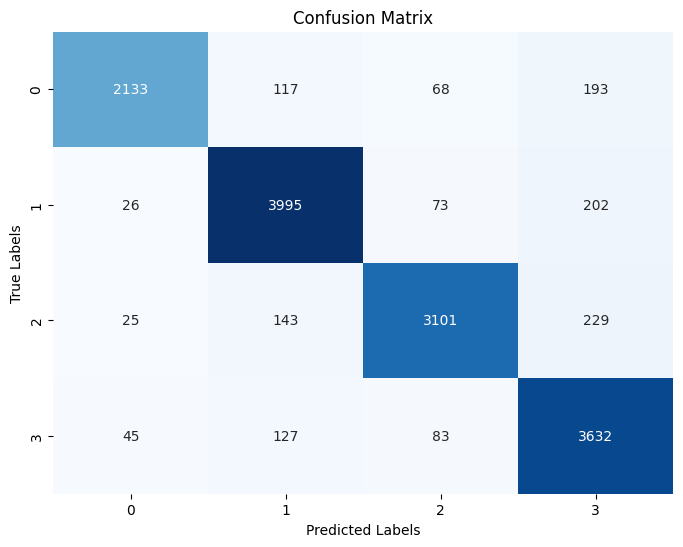

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.96      0.85      0.90      2511
    Negative       0.91      0.93      0.92      4296
     Neutral       0.93      0.89      0.91      3498
    Positive       0.85      0.93      0.89      3887

    accuracy                           0.91     14192
   macro avg       0.91      0.90      0.91     14192
weighted avg       0.91      0.91      0.91     14192



In [29]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a classification report
class_report = classification_report(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("Classification Report:")
print(class_report)